In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import argparse
import time
import pickle
from functools import partial

import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version", tf.__version__)

from include import configuration
from include import eval_utils
from include import graph_manager
from include import nets
from include import viz
from include import utils
tf.logging.set_verbosity(tf.logging.ERROR)

Tensorflow version 1.12.0


In [3]:
def draw_bounding_boxes(image, bbs, color=(1.0, 0.0, 0.0)):
    """Draw bounding boxes on the current image in Tensorflow with the specified color.
    
    Args:
        image: A Tensor of shape (batch, size, size, 3).
        bbs: A Tensor of shape (batch, n_boxes, 4) where the last axis is ordered as (xmin, ymin, xmax, ymax).
    """
    r = len(bbs.get_shape())
    assert r >= 3
    if r > 3:        
        bbs = utils.flatten_percell_output(bbs)
    mask = - tf.ones(tf.shape(image))
    mask = tf.image.draw_bounding_boxes(mask, tf.gather(bbs, [1, 0, 3, 2], axis=-1))
    mask = tf.clip_by_value(mask, -1., 0.) +1. # 0. if nothing, 1. on box position
    return (1. - mask) * image + mask * color

# Standard detector 

Returns the final mean average precision on the test set and a few vizualisations of the output boxes.

In [4]:
def evaluate_standard(log_dir, 
                      batch_size=16,
                      viz_confidence_threshold=0.25,
                      viz_confidence_threshold_2=0.5,
                      retrieval_nms_threshold=0.5,
                      retrieval_confidence_threshold=0.,
                      retrieval_iou_threshold=[0.5, 0.75],
                      output=True,
                      display=True,
                      verbose=0):
    ## Configuration
    with open(os.path.join(log_dir, 'config.pkl'), 'rb') as f:
        config = pickle.load(f)
    config['batch_size'] = batch_size
    config['nms_threshold'] = retrieval_nms_threshold
    config['retrieval_confidence_threshold'] = retrieval_confidence_threshold
    config['retrieval_iou_threshold'] = retrieval_iou_threshold 
    config['num_gpus'] = 1
    config['shuffle_test'] = True
    
    
    ############## Graph
    with tf.Graph().as_default():
        ## Inputs
        eval_split_placehoder = tf.placeholder_with_default(False, (), 'choose_eval_split')
        eval_inputs, eval_initializer = tf.cond(
            eval_split_placehoder,
            true_fn=lambda: graph_manager.get_inputs(mode='test', verbose=verbose, **config),
            false_fn=lambda: graph_manager.get_inputs(mode='val', verbose=verbose, **config),
            name='eval_inputs')
        eval_inputs = eval_inputs[0]

        ## Feed-forward
        network = configuration.get_defaults(config, ['network'], verbose=True)[0]
        forward_fn = tf.make_template(network, getattr(nets, network))
        decode_fn = tf.make_template('decode', nets.get_detection_outputs)
        forward_pass = partial(nets.forward, forward_fn=forward_fn, decode_fn=decode_fn)
        eval_outputs = forward_pass(eval_inputs['image'], config, is_training=False, verbose=verbose)

        ## Draw bounding boxes
        gt_boxes = draw_bounding_boxes(
            eval_inputs['image'], eval_inputs['bounding_boxes'], color=(0., 1., 0.))
        filtered_boxes = eval_outputs['bounding_boxes'] * tf.to_float(
            eval_outputs['confidence_scores'] > viz_confidence_threshold)
        filtered_boxes_1 =  draw_bounding_boxes(eval_inputs['image'], filtered_boxes, color=(1., 1., 0.))
        filtered_boxes = eval_outputs['bounding_boxes'] * tf.to_float(
            eval_outputs['confidence_scores'] > viz_confidence_threshold_2)
        filtered_boxes_2 =  draw_bounding_boxes(eval_inputs['image'], filtered_boxes, color=(1., 0., 1.))
        images = tf.stack([gt_boxes, filtered_boxes_1, filtered_boxes_2], axis=1)

        ## Evaluation
        eval_outputs = [eval_inputs['im_id'], eval_inputs['num_boxes'], eval_inputs['bounding_boxes'],
                        eval_outputs['bounding_boxes'], eval_outputs['detection_scores']]
        test_results_path = os.path.join(config["log_dir"], 'test_output.txt')
        eval_test = partial(graph_manager.run_eval, 
                            eval_split_placehoder=eval_split_placehoder,
                            eval_initializer=eval_initializer, 
                            eval_outputs=eval_outputs,
                            configuration=config,
                            mode='test',
                            results_path=test_results_path)


        ############## Session
        session_creator = tf.train.ChiefSessionCreator(
            checkpoint_dir=log_dir, config=tf.ConfigProto(allow_soft_placement=True))

        # Start session
        with tf.train.MonitoredSession(session_creator=session_creator) as sess:
            # evaluate
            #mean_aps, _, _ = eval_test(sess, 0)
            #print('Mean AP', np.mean(mean_aps))

            # viz
            if output or display:
                sess.run(eval_initializer)
                im_ids_, images_ = sess.run([eval_inputs['im_id'], images])                                    
                fig, axis = plt.subplots(batch_size, 3, figsize=(15, 5 * batch_size))
                for i, (im_id, image) in enumerate(zip(im_ids_, images_)):
                    axis[i][0].set_title('Ground-truth (%s)' % im_id)
                    axis[i][1].set_title('Predicted boxes (c > %.2f)' % viz_confidence_threshold)
                    axis[i][2].set_title('Predicted boxes (c > %.2f)' % viz_confidence_threshold_2)
                    for j in range(3):
                        axis[i][j].imshow(image[j])
                        axis[i][j].set_axis_off()
                fig.tight_layout()
                if output:
                    plt.savefig(os.path.join(config['log_dir'], 'prediction_example.png'), dpi=150)
                if not display:
                    plt.close(fig)

In [ ]:
%%time
from importlib import reload
from include import tf_inputs
reload(tf_inputs)
evaluate_standard('run_logs/yolo/', display=True)

CPU times: user 4min 3s, sys: 34.1 s, total: 4min 37s
Wall time: 21.5 s


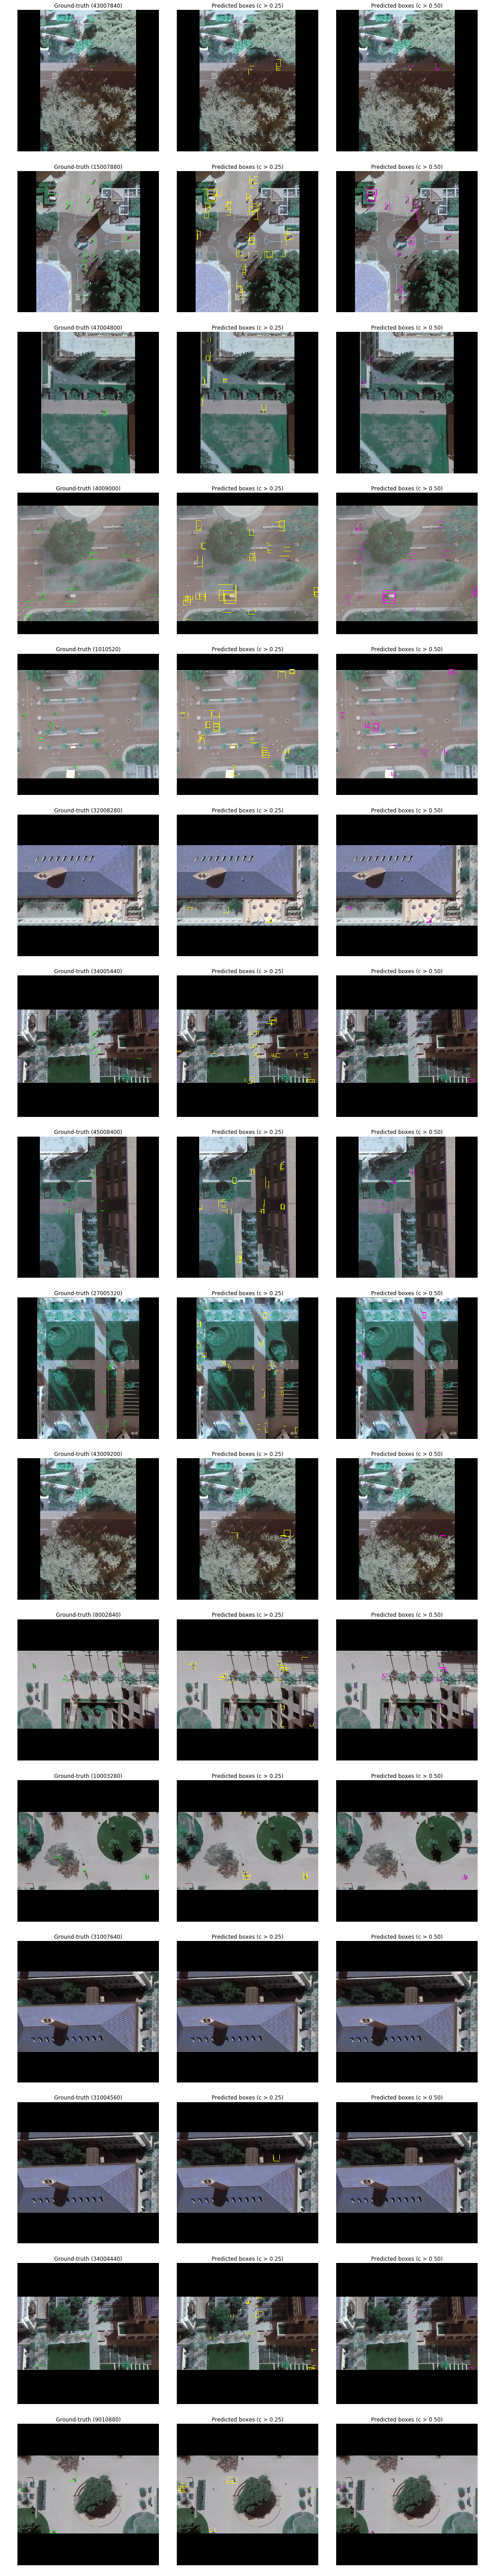

In [6]:
%%time
from importlib import reload
from include import tf_inputs
reload(tf_inputs)
evaluate_standard('run_logs/sdd/yolo_v2_standard_1024/02-21_15-09/', display=True)

In [47]:
%%time
evaluate_standard('run_logs/sdd/mobilenet_100_standard_1024/02-19_13-08/', display=False)

evaluated 3199 test images at step 0: map@0.50 = 0.41486 - map@0.75 = 0.06062
CPU times: user 14min 42s, sys: 1min 12s, total: 15min 54s
Wall time: 7min 46s


In [46]:
evaluate_standard('run_logs/sdd/mobilenet_100_standard_512/02-19_08-59/', display=False)

evaluated 3199 test images at step 0: map@0.50 = 0.26573 - map@0.75 = 0.02752


In [48]:
evaluate_standard('run_logs/sdd/mobilenet_100_standard_256/02-19_16-44/', display=False)

evaluated 3199 test images at step 0: map@0.50 = 0.10016 - map@0.75 = 0.00857


In [6]:
%%time
evaluate_standard('run_logs/mscoco/mobilenet_100_standard_416/02-21_17-00/', display=False,
                  retrieval_iou_threshold=[0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])

evaluated 4952 test images at step 0: map@0.50 = 0.39795 - map@0.55 = 0.35457 - map@0.60 = 0.30792 - map@0.65 = 0.25368 - map@0.70 = 0.19561 - map@0.75 = 0.13621 - map@0.80 = 0.08831 - map@0.85 = 0.04136 - map@0.90 = 0.01374 - map@0.95 = 0.00129
Mean AP 0.179064434102631
CPU times: user 4min 16s, sys: 47.8 s, total: 5min 4s
Wall time: 1min 49s


# ODGI detector
Returns the final mean average precision on the test set, a few vizualisations of the output boxes, and an analysis of patch occupancy.

In [9]:
from train_odgi import stage_transition, format_final_boxes

def evaluate_odgi(log_dir, 
                  batch_size=16,
                  test_num_crops=6,
                  test_patch_nms_threshold=0.25,
                  test_patch_confidence_threshold=0.1,
                  test_patch_strong_confidence_threshold=0.6,
                  viz_confidence_threshold=0.25,
                  viz_confidence_threshold_2=0.25,
                  retrieval_nms_threshold=0.5,
                  retrieval_confidence_threshold=0.,
                  retrieval_iou_threshold=[0.5, 0.75],
                  occupancy_threshold=0.25,
                  display_with_nms=False,
                  output=True,
                  display=True,
                  share_variables=False,
                  verbose=0):
    ## Configuration
    stages = []
    for i, base_name in enumerate(['stage1', 'stage2']):
        ## Config
        with open(os.path.join(log_dir, '%s_config.pkl' % base_name), 'rb') as f:
            config = pickle.load(f)
        config['nms_threshold'] = retrieval_nms_threshold
        config['retrieval_confidence_threshold'] = retrieval_confidence_threshold
        config['retrieval_iou_threshold'] = retrieval_iou_threshold 
        config['num_gpus'] = 1
        config['shuffle_test'] = True
        config['test_num_crops'] = test_num_crops
        config['test_patch_nms_threshold'] = test_patch_nms_threshold
        config['test_patch_confidence_threshold'] = test_patch_confidence_threshold
        config['test_patch_strong_confidence_threshold'] = test_patch_strong_confidence_threshold
        ## Templates
        if not share_variables:
            network_name = configuration.get_defaults(config, ['network'], verbose=True)[0]
            forward_fn = tf.make_template('%s/%s' % (base_name, network_name), getattr(nets, network_name)) 
        elif i == 0:
            network_name = configuration.get_defaults(config, ['network'], verbose=True)[0]
            forward_fn = tf.make_template(network_name, getattr(nets, network_name)) 
        if i == 0:
            decode_fn = tf.make_template('%s/decode' % base_name, nets.get_detection_outputs_with_groups)
        else:
            decode_fn = tf.make_template('%s/decode' % base_name, nets.get_detection_outputs)
        forward_pass = partial(nets.forward, forward_fn=forward_fn, decode_fn=decode_fn)
        stages.append((base_name, network_name, forward_pass, config))
    
    stages[0][-1]['batch_size'] = batch_size
    stages[1][-1]['previous_batch_size'] = batch_size
    
    ############## Graph
    with tf.Graph().as_default():
        ## Inputs
        eval_split_placehoder = tf.placeholder_with_default(False, (), 'choose_eval_split')                  
        eval_inputs, eval_initializer = tf.cond(
            eval_split_placehoder,
            true_fn=lambda: graph_manager.get_inputs(mode='test', verbose=0, **stages[0][3]),
            false_fn=lambda: graph_manager.get_inputs(mode='val', verbose=0, **stages[0][3]),
            name='eval_inputs')
        eval_inputs = eval_inputs[0]

        ## Feed-forward
        stage_inputs = eval_inputs
        image_ids = stage_inputs['im_id']
        num_boxes = stage_inputs['num_boxes']
        gt_bbs = stage_inputs['bounding_boxes']

        for s, (name, _, forward_pass, stage_config) in enumerate(stages):                    
            if s > 0:
                stage_inputs = stage_transition(
                    stage_inputs, stage_outputs, 'test', stage_config, verbose=0)
            # stage 1
            if s == 1:
                stage1_pred_bbs = stage_outputs['bounding_boxes']
                stage1_pred_confidences = stage_outputs['detection_scores']
                stage1_kept_out_boxes = stage_outputs['kept_out_filter']
                crop_boxes = stage_outputs['crop_boxes']
                group_flags = stage_outputs['group_classification_logits']
                
            stage_outputs = forward_pass(
                stage_inputs['image'], stage_config, is_training=False, verbose=0)

            # stage 2 (final)
            if s == 1:                    
                stage_outputs = format_final_boxes(stage_outputs, crop_boxes)
                stage2_pred_bbs = stage_outputs['bounding_boxes']
                stage2_pred_confidences = stage_outputs['detection_scores']
                
        ## Evaluation
        eval_outputs = [image_ids, num_boxes, gt_bbs, stage2_pred_bbs, stage2_pred_confidences,
                        stage1_pred_bbs, stage1_pred_confidences, stage1_kept_out_boxes]  
        test_results_path = os.path.join(config["log_dir"], 'test_output.txt')
        eval_test = partial(graph_manager.run_eval, 
                            eval_split_placehoder=eval_split_placehoder,
                            eval_initializer=eval_initializer, 
                            eval_outputs=eval_outputs,
                            configuration=config,
                            mode='test',
                            results_path=test_results_path)
        
        # Occupancy rate
        # intersection between groupd-truth bounding boxes and crops
        inters = utils.get_intersection_ratio(                                       
            tf.split(tf.transpose(eval_inputs['bounding_boxes'], (0, 2, 1)), 4, axis=1), 
            tf.split(crop_boxes, 4, axis=-1))
        # is_non_empty: How many ground-truth boxes are "usefully" present in each crop 
        occupied_filter = tf.to_float(inters > occupancy_threshold)
        is_non_empty = tf.reduce_sum(occupied_filter, axis=-1)
        # average over the number of crops
        occupancy_rate = tf.reduce_sum(tf.to_float(is_non_empty > 0), axis=1)
        occupancy_rate = tf.reduce_sum(occupancy_rate)
        # coverage: how many of the ground-truth bbs are actually covered
        coverage = tf.to_float(tf.reduce_sum(occupied_filter, axis=1) > 0)
        coverage = tf.reduce_sum(coverage, axis=1)
        coverage = coverage / (tf.to_float(eval_inputs['num_boxes']) + 1e-8)
        coverage = tf.reduce_sum(coverage)
        num_samples = tf.shape(inters)[0]
        num_nonempty_samples = tf.reduce_sum(tf.to_float(eval_inputs['num_boxes'] > 0))

        ## Draw bounding boxes
        #ground-truth
        gt_boxes = draw_bounding_boxes(
            eval_inputs['image'], eval_inputs['bounding_boxes'], color=(0., 1., 0.))        
        #predicted groups
        stage1_filter = tf.to_float(stage1_pred_confidences > viz_confidence_threshold)
        group_flags = tf.to_float(tf.nn.sigmoid(group_flags) >= 0.5)
        group_bbs = stage1_pred_bbs * group_flags * stage1_filter
        # non maximum suppression
        if display_with_nms:
            group_bbs = utils.flatten_percell_output(group_bbs)
            stage1_pred_confidences = utils.flatten_percell_output(stage1_pred_confidences)
            filtered_group_bbs = []
            max_output_size = tf.shape(group_bbs)[1]
            for i in range(batch_size):
                filtered_group_bbs.append(utils.nms_with_pad(
                        group_bbs[i], stage1_pred_confidences[i, :, 0], max_output_size)[0])
            group_bbs = tf.stack(filtered_group_bbs, axis=0)
        groups = draw_bounding_boxes(eval_inputs['image'], group_bbs, color=(1., 0., 1.))
        # Short-cut individuals
        individuals = utils.flatten_percell_output((1. - group_flags) * stage1_filter * stage1_pred_bbs)
        shortcut_individuals = tf.expand_dims(stage1_kept_out_boxes, axis=-1) * individuals
        shortcut_boxes = draw_bounding_boxes(
            eval_inputs['image'], individuals, color=(0., 0., 1.))
        shortcut_boxes = draw_bounding_boxes(
            shortcut_boxes, shortcut_individuals, color=(0., 1., 1.))
        # Crops (after offsets)
        crops = draw_bounding_boxes(eval_inputs['image'], crop_boxes, color=(1., 1., 1.))
        # outputs from stage 2
        stage2_pred_bbs *= tf.to_float(stage2_pred_confidences > viz_confidence_threshold_2)
        stage2_boxes = draw_bounding_boxes(eval_inputs['image'], stage2_pred_bbs, color=(1., 1., 0.))    
        # All outputs, combined with 
        all_boxes = draw_bounding_boxes(eval_inputs['image'], stage2_pred_bbs, color=(1., 0., 1.))
        all_boxes = draw_bounding_boxes(all_boxes, shortcut_individuals, color=(1., 0., 1.))
        # Return
        images = tf.stack([gt_boxes, groups, shortcut_boxes, crops, stage2_boxes, all_boxes], axis=1)



        ############## Session
        session_creator = tf.train.ChiefSessionCreator(
            checkpoint_dir=log_dir, config=tf.ConfigProto(allow_soft_placement=True))

        # Start session
        with tf.train.MonitoredSession(session_creator=session_creator) as sess:
            # evaluate
            ##mean_aps, _, _ = eval_test(sess, 0)
            #print('Mean AP', np.mean(mean_aps))

            # occupancy rate            
            sess.run(eval_initializer)
            aux = np.zeros((4,))
            try:
                while 1:
                    aux += sess.run([occupancy_rate, coverage, num_nonempty_samples, num_samples])
            except tf.errors.OutOfRangeError:
                pass
            print('num samples:', int(aux[-1]))
            print('avg. occupancy rate:', aux[0] / aux[-2])
            print('avg. coverage:', aux[1] / aux[-2])

            # viz
            if output or display:
                sess.run(eval_initializer)
                im_ids_, images_ = sess.run([eval_inputs['im_id'], images])                                    
                fig, axis = plt.subplots(batch_size, 6, figsize=(18, 3 * batch_size))
                for i, (im_id, image) in enumerate(zip(im_ids_, images_)):
                    axis[i][0].set_title('Ground-truth (%s)' % im_id, fontsize=8)
                    axis[i][1].set_title(
                        'Predicted groups (c > %.2f)' % viz_confidence_threshold, fontsize=8)
                    axis[i][2].set_title('Individuals (c > %.2f)' % viz_confidence_threshold, fontsize=8)
                    axis[i][3].set_title('Extracted crops (%d)' % test_num_crops, fontsize=8)
                    axis[i][4].set_title(
                        'Stage 2 outputs (c > %.2f)' % viz_confidence_threshold_2, fontsize=8)
                    axis[i][5].set_title(
                        'All predictions (c > %.2f)' % viz_confidence_threshold_2, fontsize=8)
                    for j in range(6):
                        axis[i][j].imshow(image[j])
                        axis[i][j].set_axis_off()
                fig.tight_layout()
                if output:
                    plt.savefig(os.path.join(config['log_dir'], 'prediction_example.png'), dpi=200)
                if not display:
                    plt.close(fig)

num samples: 4402
avg. occupancy rate: 3.215752146323255
avg. coverage: 0.6896785857985384
CPU times: user 1h 14min 40s, sys: 26min 51s, total: 1h 41min 31s
Wall time: 4min 28s


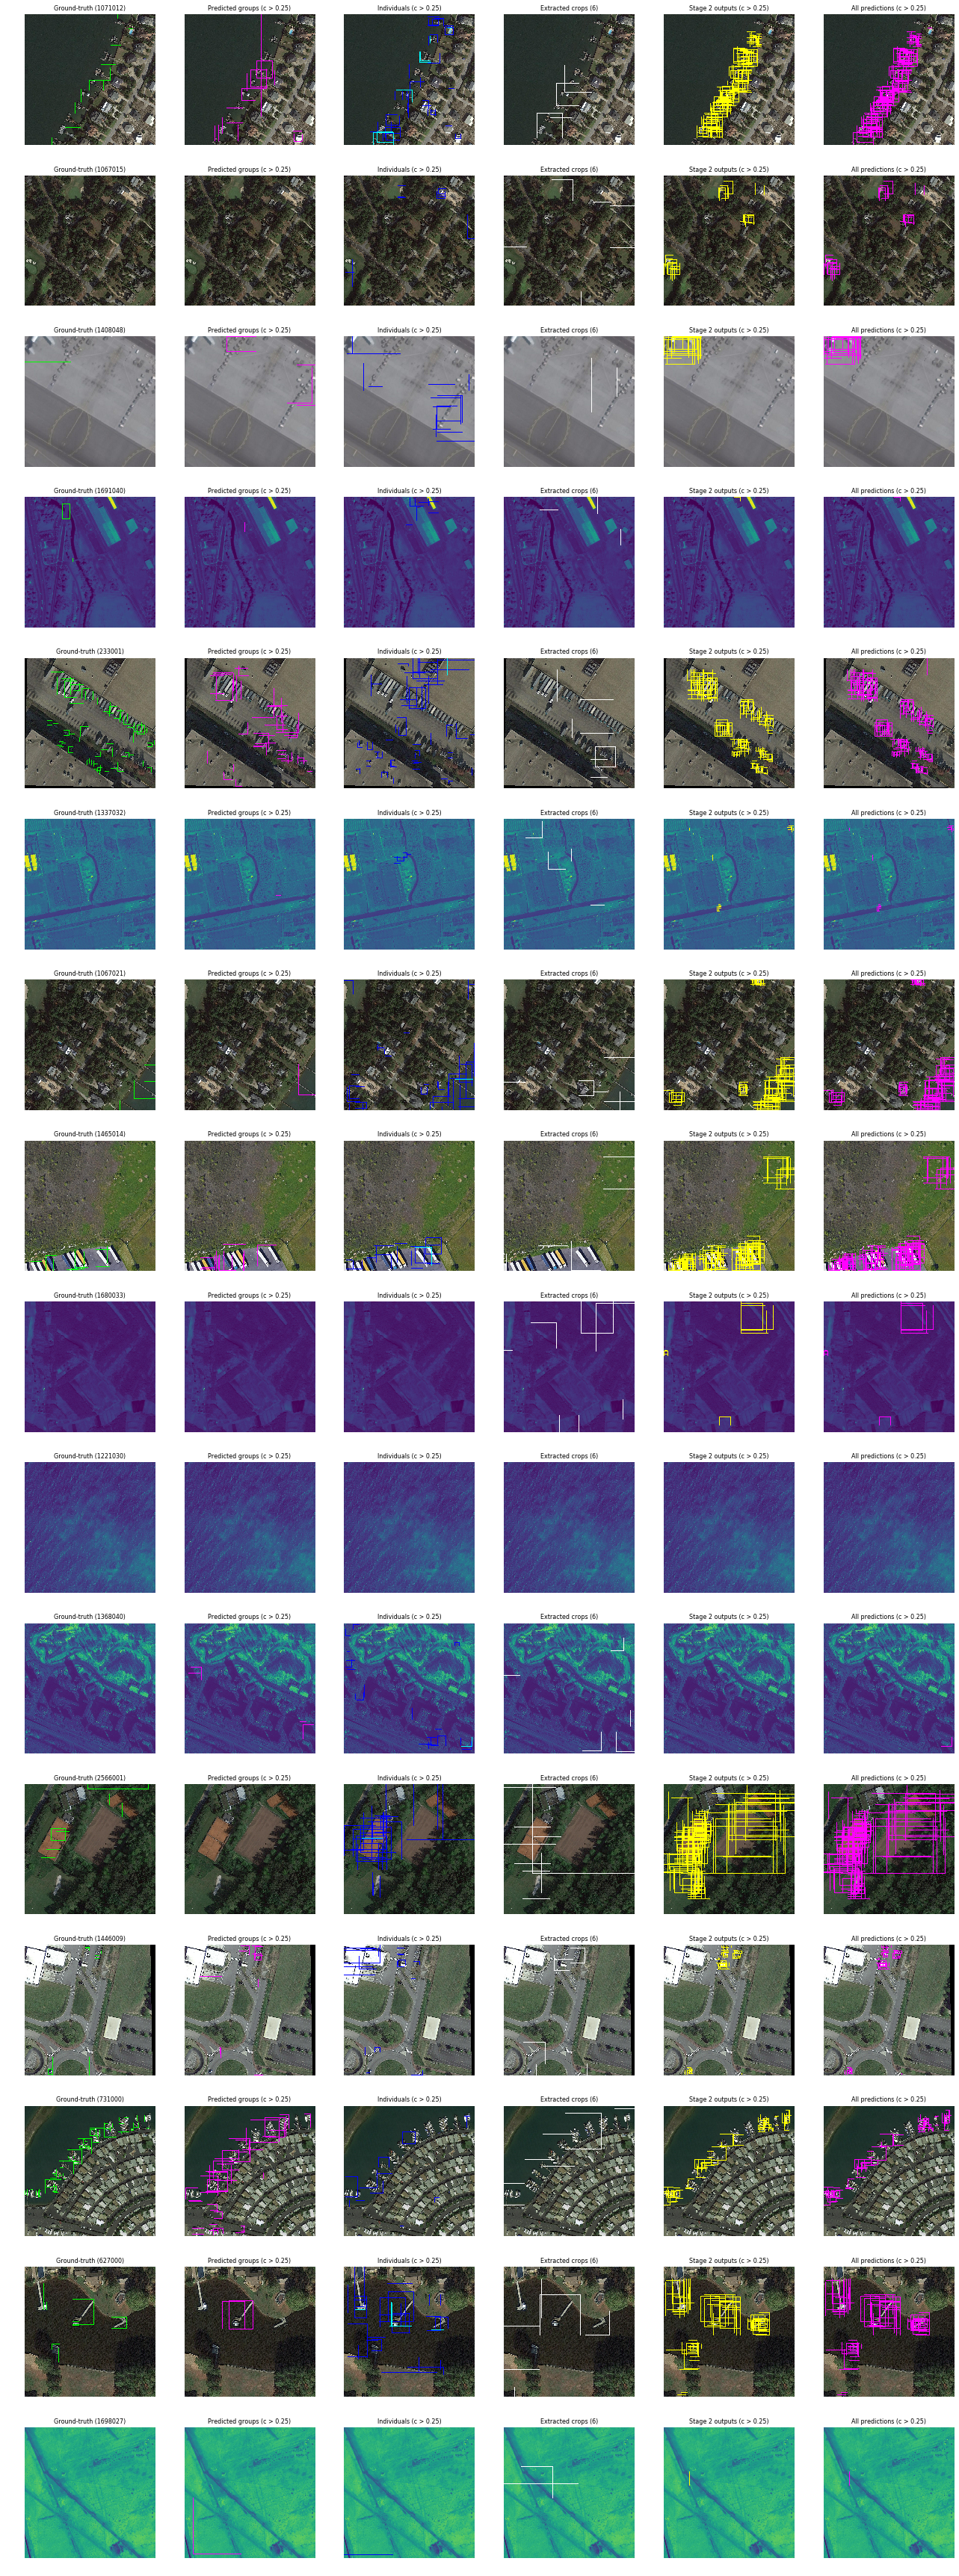

In [10]:
%%time
evaluate_odgi('run_logs/dota/tiny_yolo_v2_odgi_512_256/06-20_09-48/', display=True)

#### SDD

In [121]:
%%time
evaluate_odgi('run_logs/sdd/mobilenet_100_odgi_512_256/02-19_20-17/', display=False)

evaluated 3199 test images at step 0: map@0.50 = 0.42466 - map@0.75 = 0.05473
num samples: 3281
avg. occupancy rate: 4.433260393873085
avg. coverage: 0.8007358196900389
CPU times: user 12min 40s, sys: 1min 11s, total: 13min 52s
Wall time: 3min 21s


In [122]:
evaluate_odgi('run_logs/sdd/mobilenet_100_odgi_512_128/02-20_10-54/', display=False)

evaluated 3199 test images at step 0: map@0.50 = 0.34270 - map@0.75 = 0.04287
num samples: 3281
avg. occupancy rate: 4.416380118787121
avg. coverage: 0.8049052227434049


In [7]:
evaluate_odgi('run_logs/sdd/mobilenet_100_odgi_512_64/02-21_10-11/', display=False)

evaluated 3199 test images at step 0: map@0.50 = 0.26494 - map@0.75 = 0.03185
Mean AP 0.14839477205128015
num samples: 3281
avg. occupancy rate: 4.389809315411066
avg. coverage: 0.8003934904089866


In [119]:
evaluate_odgi('run_logs/sdd/mobilenet_100_odgi_256_128/02-20_10-54/', display=False)

evaluated 3199 test images at step 0: map@0.50 = 0.29058 - map@0.75 = 0.03388
num samples: 3281
avg. occupancy rate: 4.162863394810878
avg. coverage: 0.7965519690409271


#### MSCOCO

In [37]:
%%time
evaluate_odgi('run_logs/mscoco/mobilenet_100_odgi_224_128/02-27_15-29/', display=False, display_with_nms=True, 
              retrieval_iou_threshold=[0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])

evaluated 4952 test images at step 0: map@0.50 = 0.34899 - map@0.55 = 0.31521 - map@0.60 = 0.28145 - map@0.65 = 0.24314 - map@0.70 = 0.19962 - map@0.75 = 0.15593 - map@0.80 = 0.10675 - map@0.85 = 0.05529 - map@0.90 = 0.01919 - map@0.95 = 0.00276
Mean AP 0.17283341361353483
num samples: 5000
avg. occupancy rate: 2.0785541195476576
avg. coverage: 0.9620532007325254
CPU times: user 6min 21s, sys: 31 s, total: 6min 52s
Wall time: 1min 50s


In [38]:
%%time
evaluate_odgi('run_logs/mscoco/mobilenet_100_odgi_416_224/02-27_16-00/', display=False, display_with_nms=True,
                  retrieval_iou_threshold=[0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])

evaluated 4952 test images at step 0: map@0.50 = 0.41239 - map@0.55 = 0.38223 - map@0.60 = 0.34723 - map@0.65 = 0.30446 - map@0.70 = 0.25496 - map@0.75 = 0.20266 - map@0.80 = 0.14118 - map@0.85 = 0.08279 - map@0.90 = 0.02721 - map@0.95 = 0.00382
Mean AP 0.21589320230875103
num samples: 5000
avg. occupancy rate: 2.666599353796446
avg. coverage: 0.9807983072585936
CPU times: user 12min 22s, sys: 45.9 s, total: 13min 8s
Wall time: 4min 4s


#### Test variables sharing

In [6]:
# Two optimizers
evaluate_odgi('run_logs/sdd/tiny_yolo_v2_odgi_512_256/03-04_11-16/', share_variables=True, display=False)

evaluated 3199 test images at step 0: map@0.50 = 0.34196 - map@0.75 = 0.03352
Mean AP 0.1877356374196042
num samples: 3281
avg. occupancy rate: 4.1822444513910595
avg. coverage: 0.7449909188144466


In [5]:
# Two optimizers, 5 epochs delay
evaluate_odgi('run_logs/sdd/tiny_yolo_v2_odgi_512_256/03-04_18-00/', share_variables=True, display=False)

evaluated 3199 test images at step 0: map@0.50 = 0.34225 - map@0.75 = 0.03835
Mean AP 0.1903003157516878
num samples: 3281
avg. occupancy rate: 4.317911847452329
avg. coverage: 0.7744852383832106
